In [1]:
# !pip install tqdm
# !pip install matplotlib
# !pip install seaborn

%load_ext autoreload

%autoreload 2

In [2]:
import sys
import os
#make the self written stuff findeable independent on who downloads it
#sts.path.append( ) makes the module importable
# os.path.dirname(os.getcwd()) provides the parent directory
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
sys.path.append("Documents/GitHub/tensorflow_1.X_playground/regression/")

In [4]:
#sys.path

In [5]:
from helpers import _TFColor, colors
import helpers
TFColor = helpers._TFColor()

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res



from data.generators import ToyDataset

 
 
from tensorflow.python.platform import tf_logging as logging
 
logging.set_verbosity(logging.INFO)

In [7]:
figsize(20,7)

In [8]:

logging.log(logging.INFO, "Tensorflow version " + tf.__version__)

INFO:tensorflow:Tensorflow version 1.13.1


In [9]:
DATA_SEQ_LEN = 300#240

In [10]:
dataset_unshuffled = ToyDataset(DATA_SEQ_LEN,1)

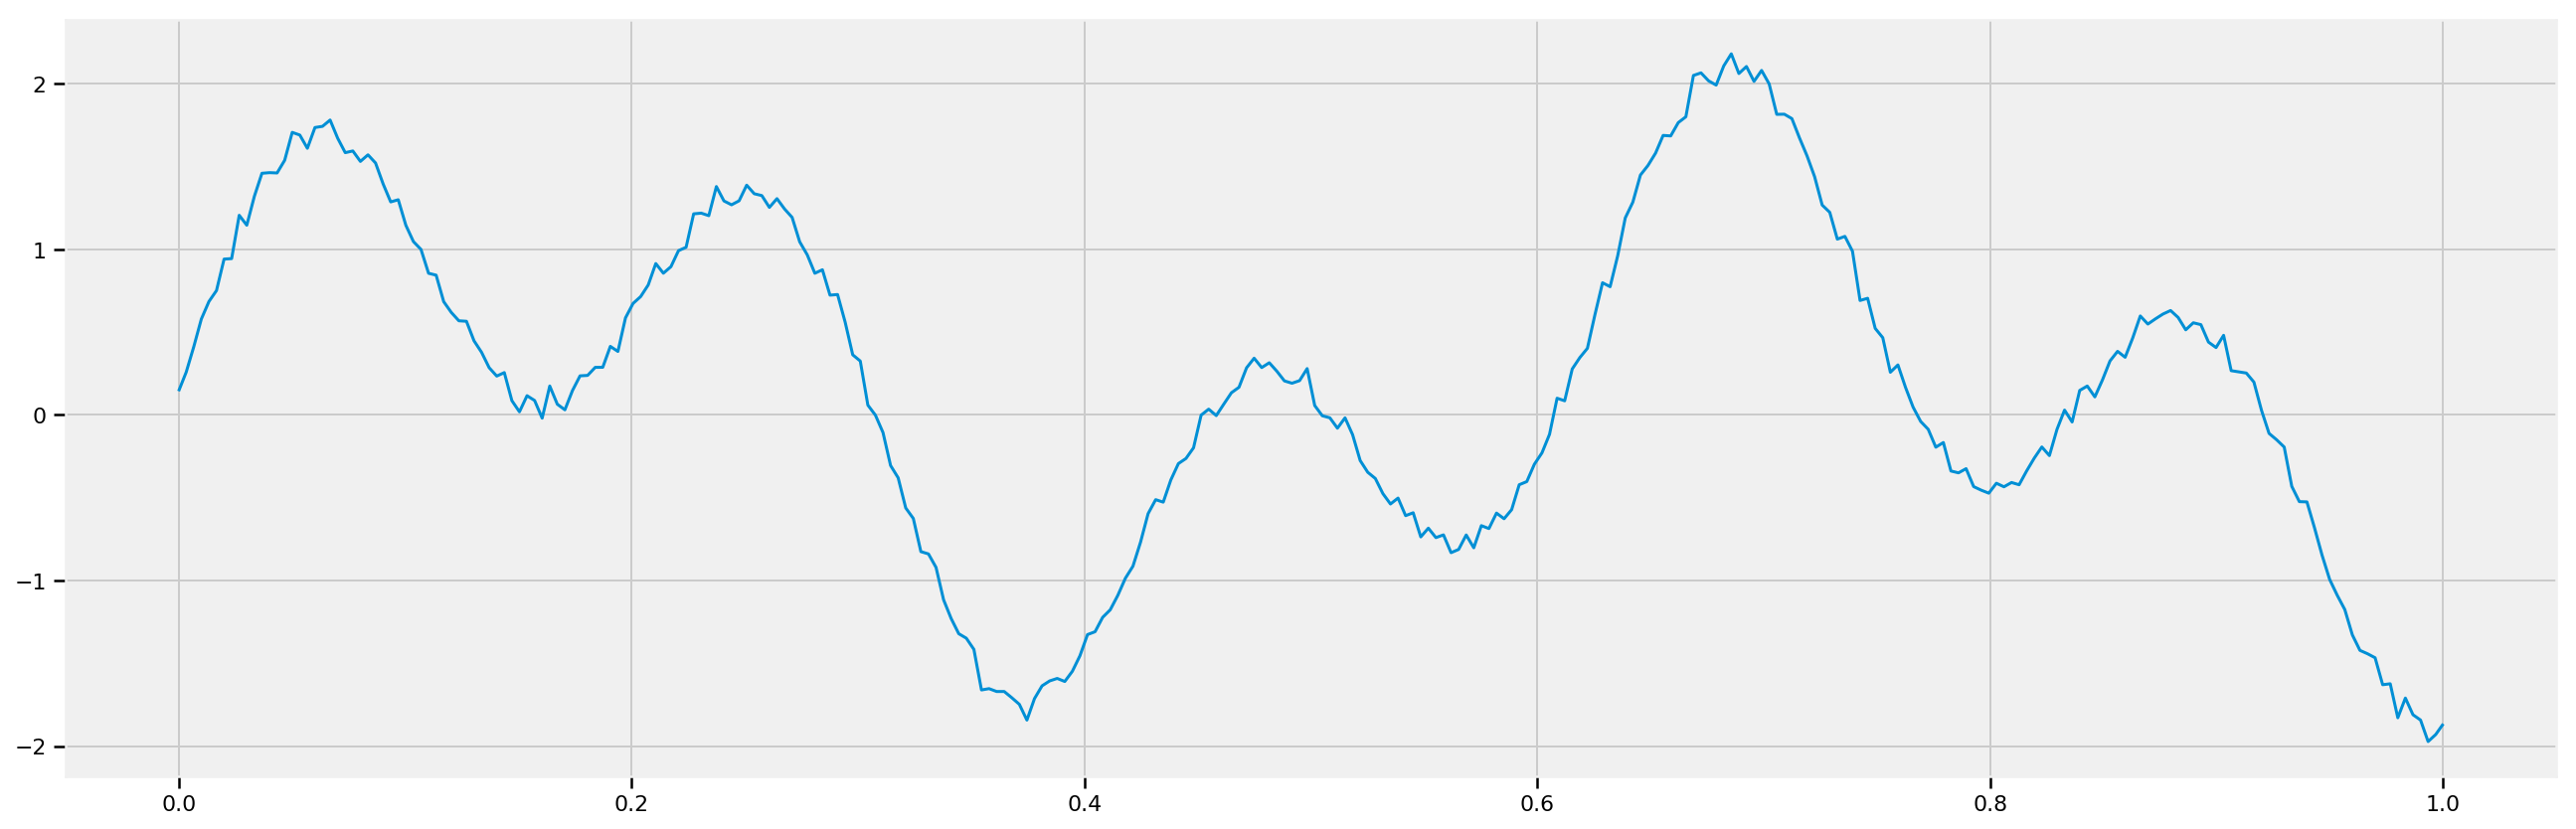

In [11]:
plt.plot(dataset_unshuffled.X,dataset_unshuffled.y)

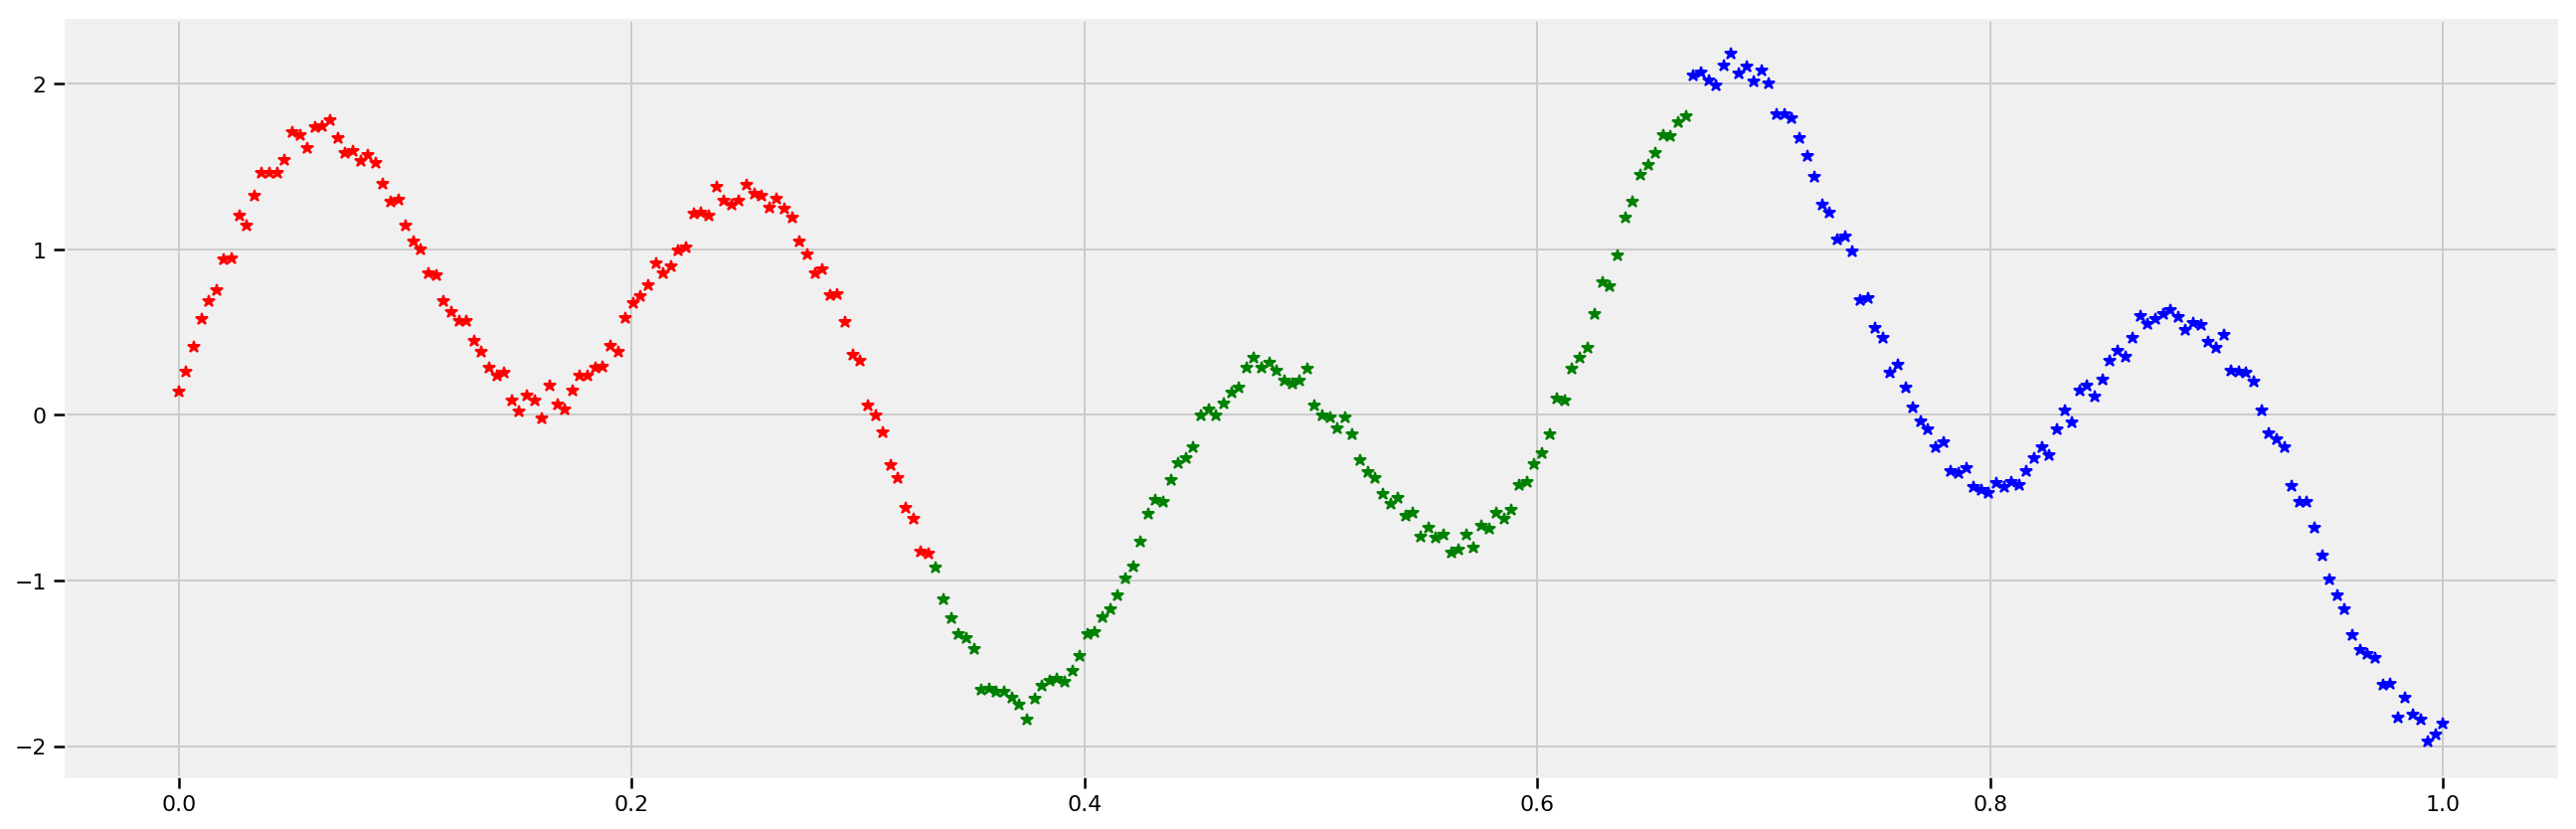

In [12]:

with tf.Session() as sess:
    for i in range(3):
        sess.run(tf.global_variables_initializer())
        X_plot,y_plot = sess.run(dataset_unshuffled.iterator.get_next())
        plt.plot(X_plot,y_plot,"{}*".format(colors[i]))
        #plt.plot(X_plot,y_plot, 'k*', markersize=10)


Next we try and see what happens if we shuffle(shuffle_buffer) the dataset with different parameters - shuffle doesn't shuffle the WHOLE dataset, instead it shuffles the next {shuffle_buffer} examples. This is done so the dataset does not have to fit in memory as a whole for shuffling.

If shuffle_buffer isn't specified (shuffle isn't called) it simply takes the next N datapoints and puts them into a batch.

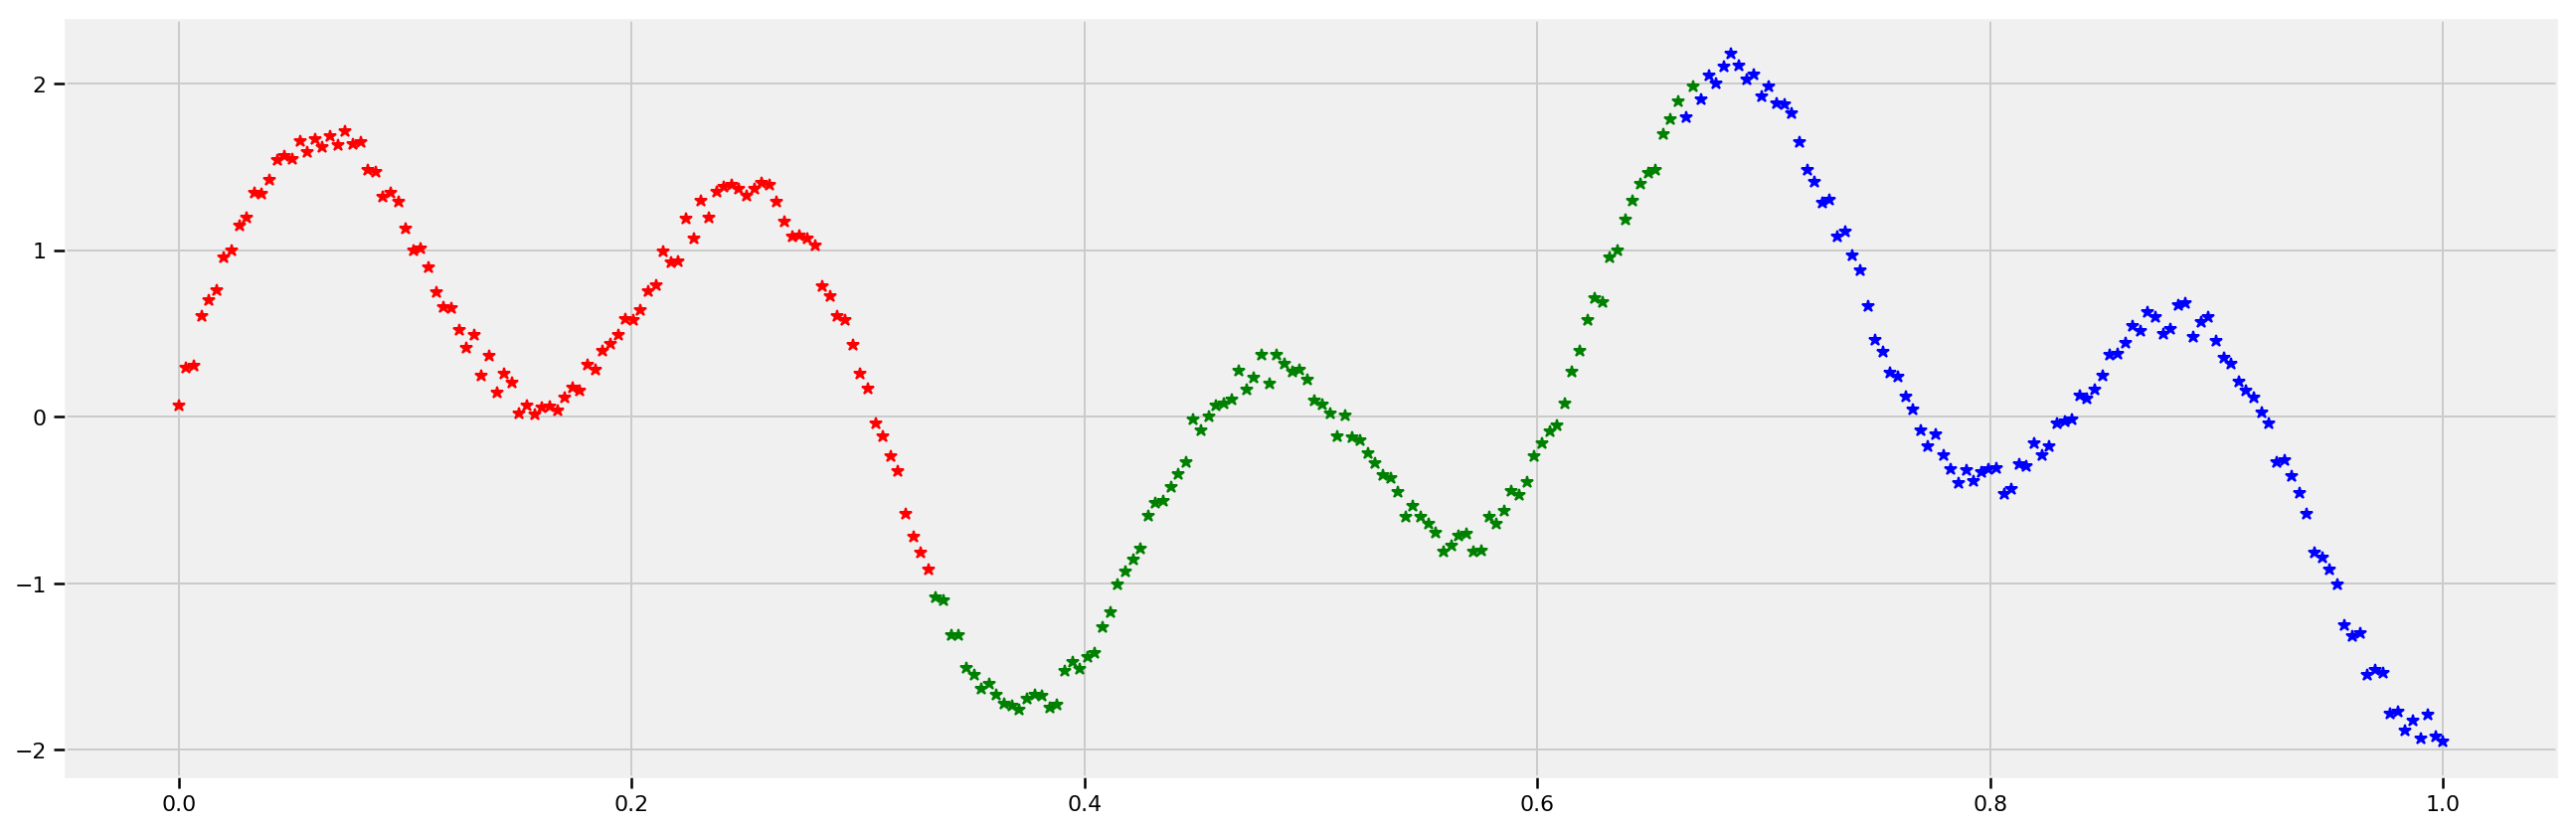

In [13]:
dataset_tmp = ToyDataset(DATA_SEQ_LEN,2)


with tf.Session() as sess:
    for i in range(3):
        sess.run(tf.global_variables_initializer())
        X_plot,y_plot = sess.run(dataset_tmp.iterator.get_next())
        plt.plot(X_plot,y_plot,"{}*".format(colors[i]))
        #plt.plot(X_plot,y_plot, 'k*', markersize=10)



having a shuffle buffer of 2 scrambles up the dataset slightly, by randomly sampling the sequence of the next two datapoints - i.e. [d1,d2] or [d2,d1] before putting them into a batch.

_Note the lonely clue dot in the red part of the graph_

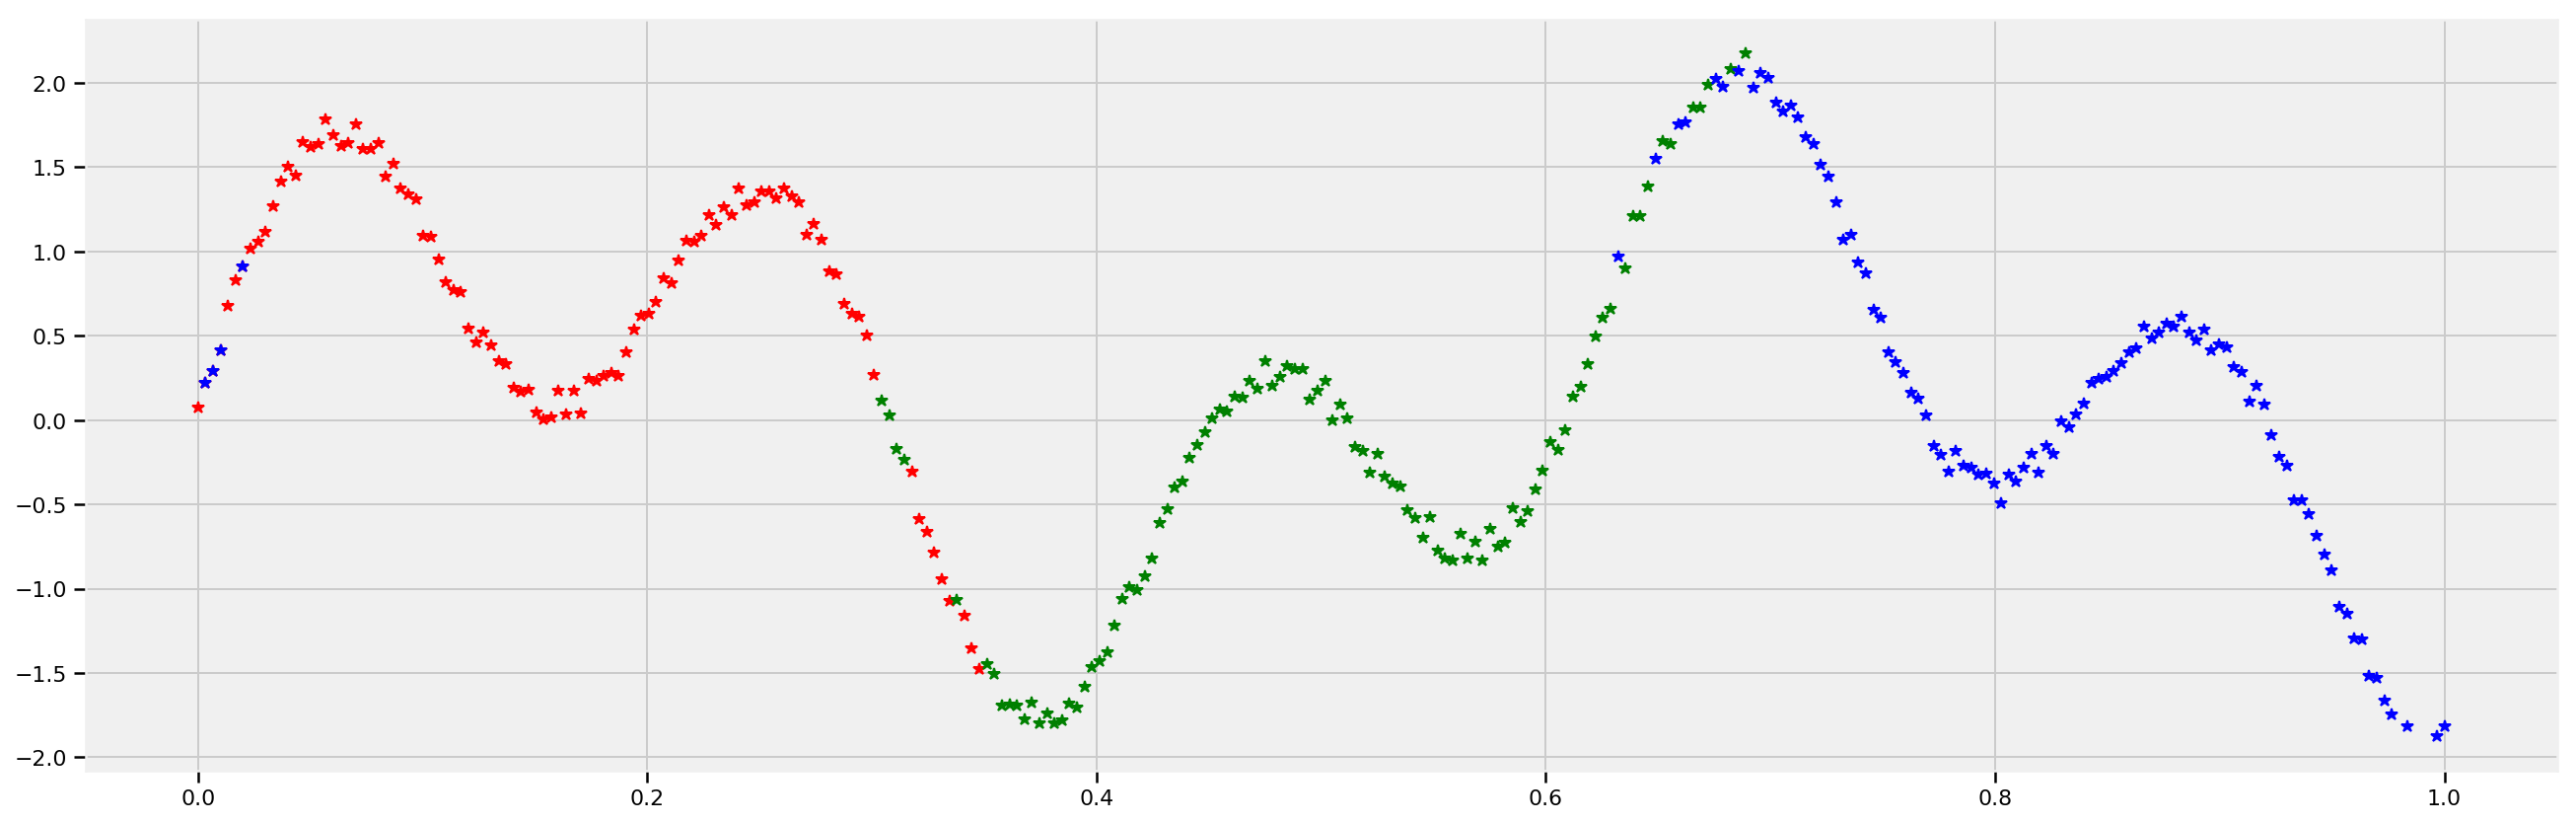

In [14]:
dataset_tmp = ToyDataset(DATA_SEQ_LEN,10)

with tf.Session() as sess:
    for i in range(3):
        sess.run(tf.global_variables_initializer())
        X_plot,y_plot = sess.run(dataset_tmp.iterator.get_next())
        plt.plot(X_plot,y_plot,"{}*".format(colors[i]))
        #plt.plot(X_plot,y_plot, 'k*', markersize=10)


Ten does the same thing for the next ten datapoints - while the dataset itself (black stars) is unchanced, the order in which the data points are shown is more random.

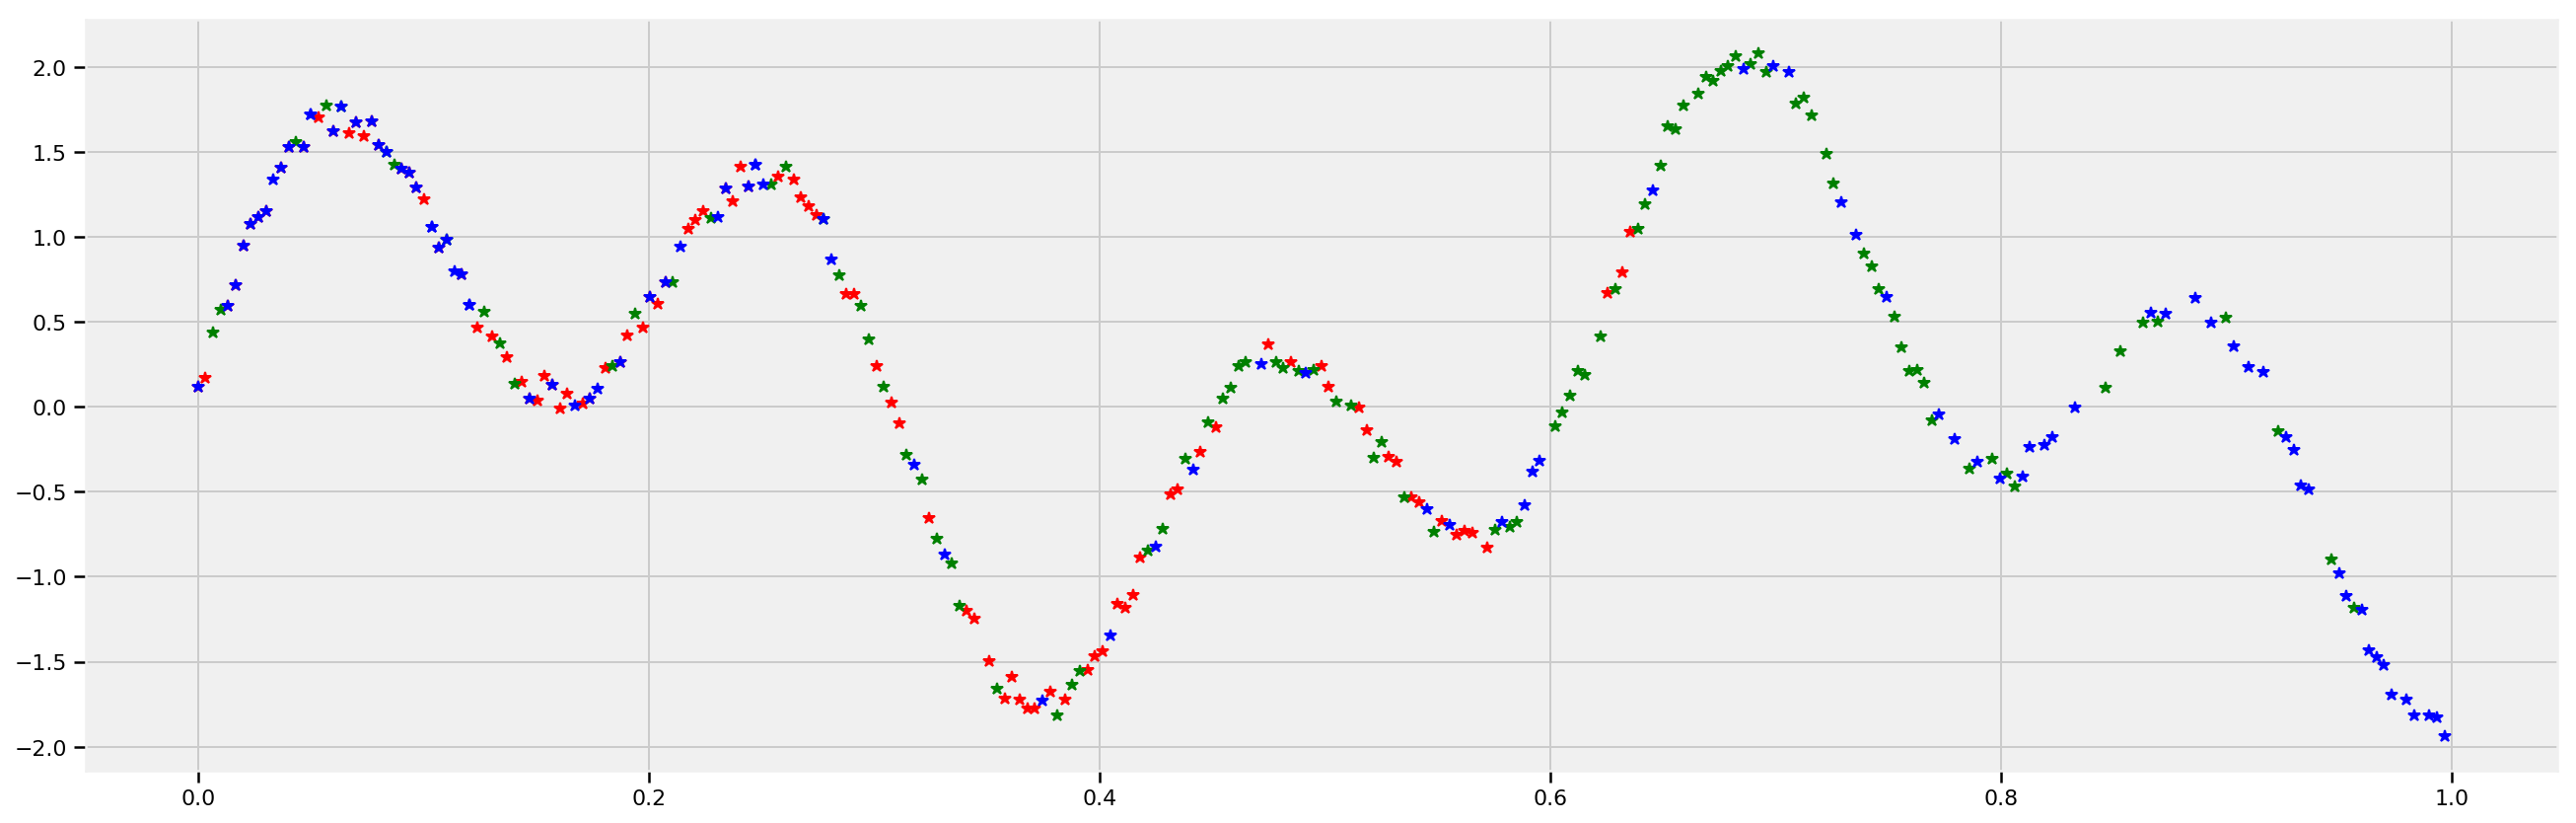

In [15]:
dataset_tmp = ToyDataset(DATA_SEQ_LEN,100)

with tf.Session() as sess:
    for i in range(3):
        sess.run(tf.global_variables_initializer())
        X_plot,y_plot = sess.run(dataset_tmp.iterator.get_next())
        plt.plot(X_plot,y_plot,"{}*".format(colors[i]))


In [16]:
del dataset_tmp

if our shuffle buffer is the same size as the batch we get a chaotic distribution over the datapoints, but we can still kind of make out clusters

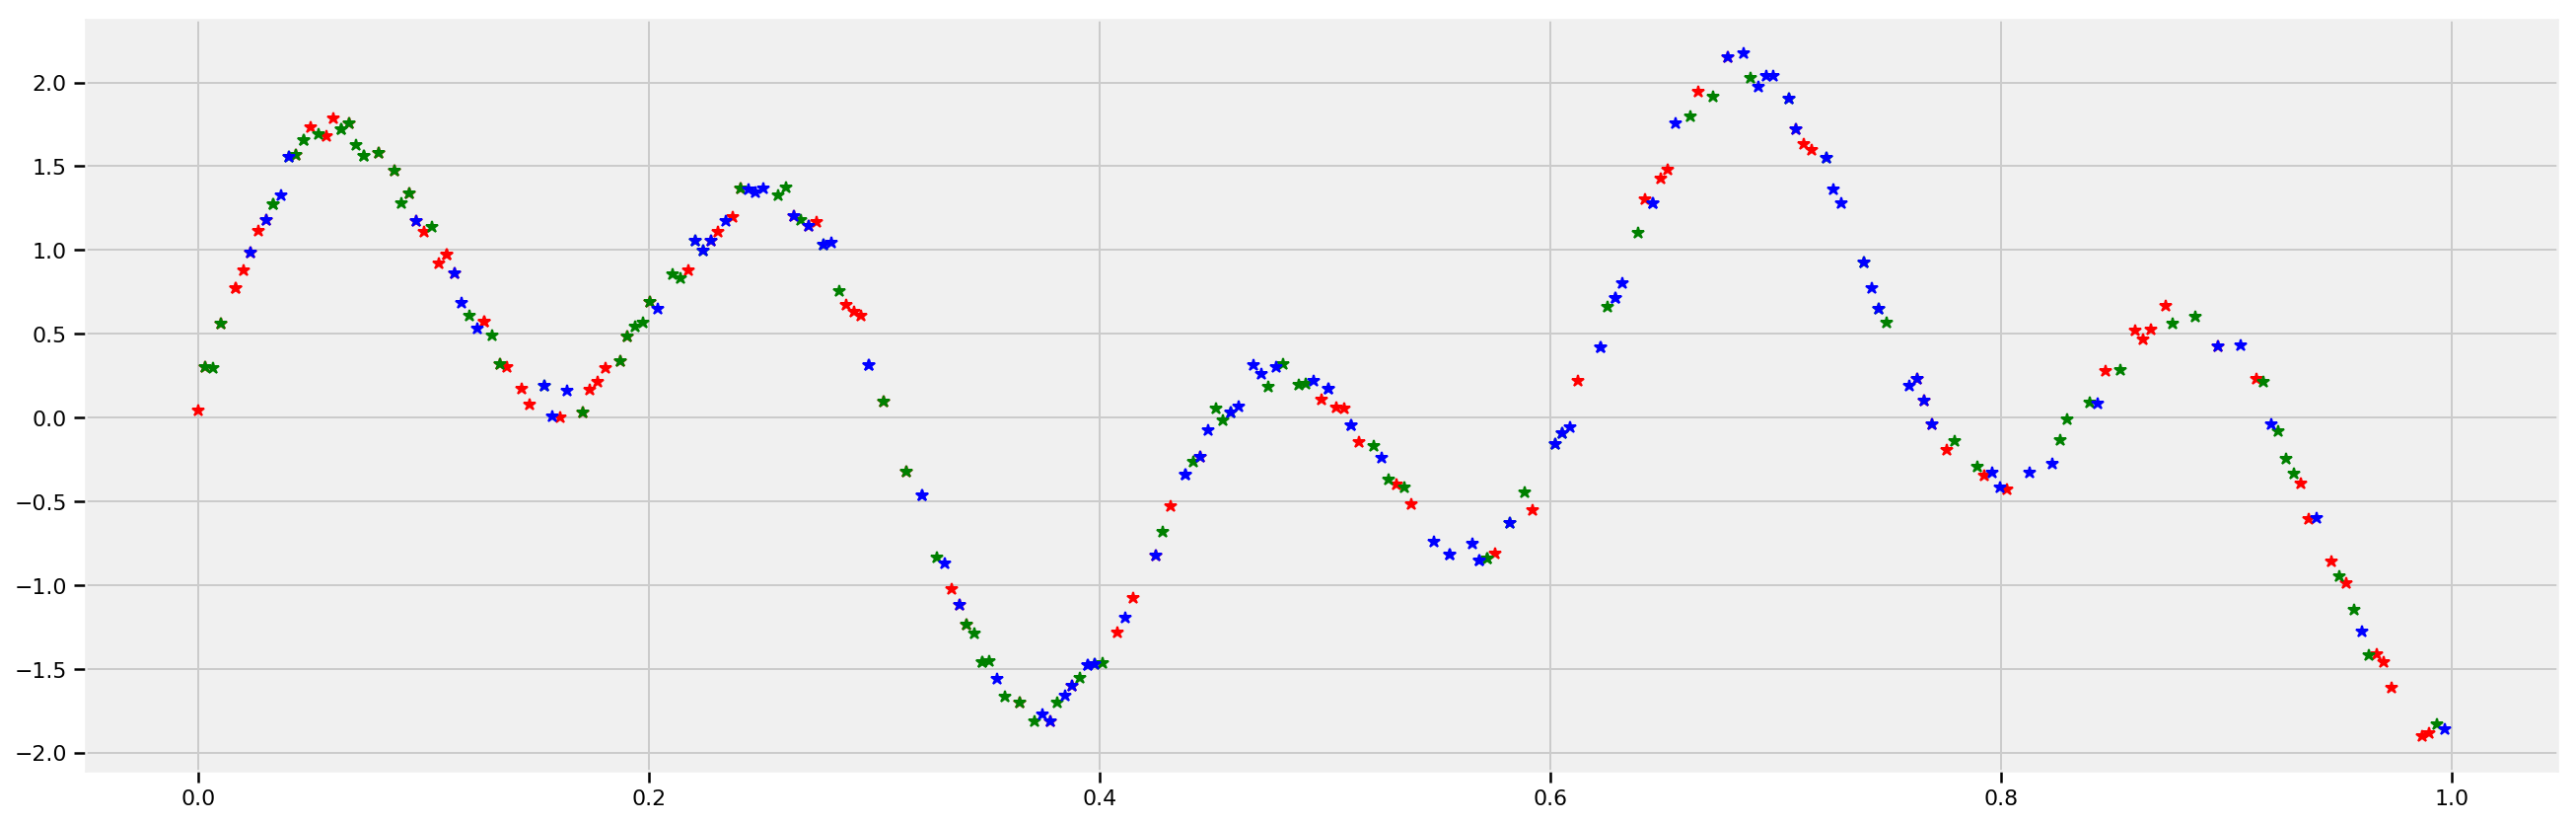

In [17]:
dataset_shuffled = ToyDataset(DATA_SEQ_LEN,DATA_SEQ_LEN)

with tf.Session() as sess:
    for i in range(3):
        sess.run(tf.global_variables_initializer())
        X_plot,y_plot = sess.run(dataset_shuffled.iterator.get_next())
        plt.plot(X_plot,y_plot,"{}*".format(colors[i]))
        #plt.plot(X_plot,y_plot, 'k*', markersize=10)


# Export the Dataset Graph

in order to use the dataset defined with tf.Datasets, we need to have access to the graph - otherwise the Session doesn't know what to do with it. This actually took some time to figure out... 

In [18]:
num_samples = 3 #we'll see so many samples from the loaded graphs

In [19]:
gdef = dataset_unshuffled.graph()

In [20]:
#gdef

we'll verify that the definition of the graph is properly saved and can be loaded - and that it preserves the parameters for batch and shuffle, as this might be an issue if it doesn't happen.

verify data batch lenght first

thats in the loaded dataset graph:
[<tf.Tensor 'import/X:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'import/y:0' shape=(?, 1) dtype=float32>, <tf.Operation 'import/next' type=Identity>]
the fetched data batches have length 100 
 


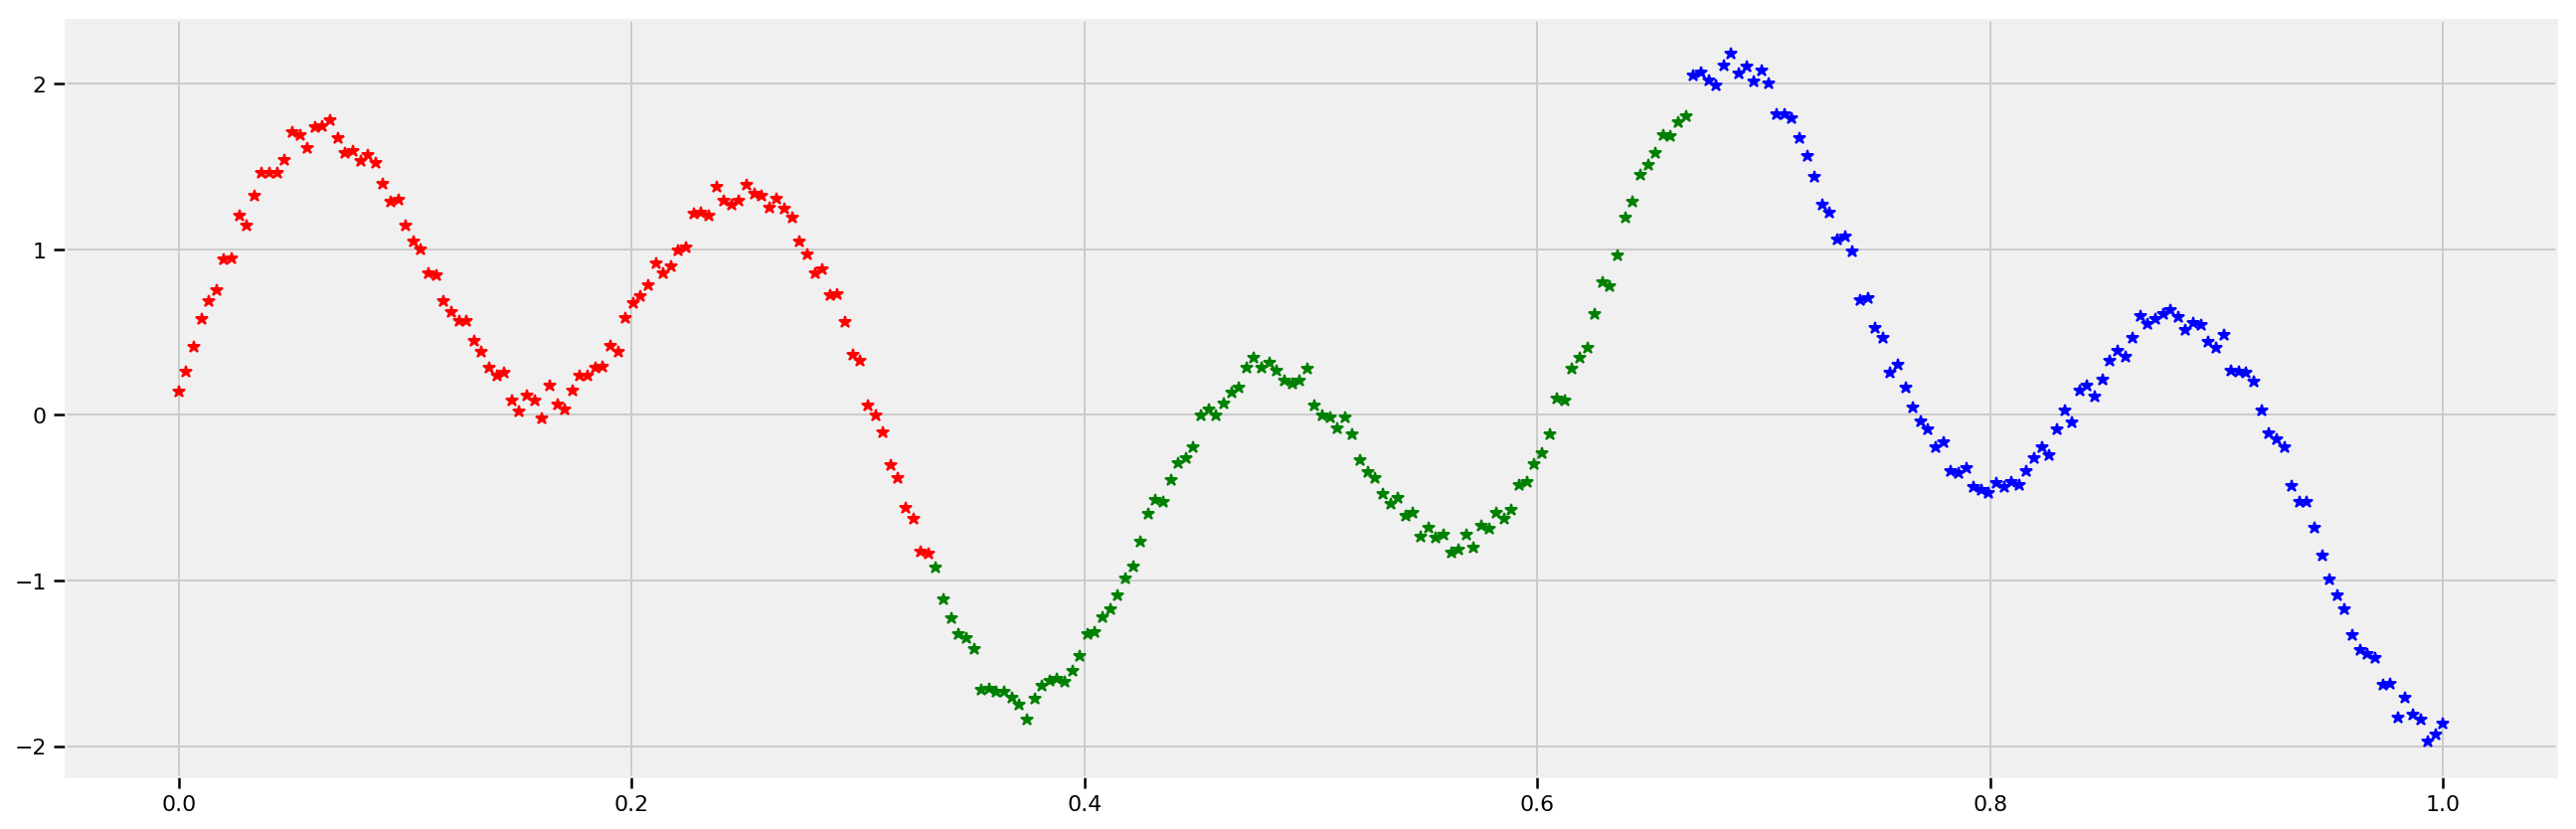

In [21]:
g2 = tf.Graph()

with g2.as_default():
    dataset_graph = tf.import_graph_def(gdef, return_elements = ['X:0',"y:0", 'next'])
    next_ = g2.get_tensor_by_name('import/next:0')

    with tf.Session() as sess:
        for i in range(num_samples):
            X_, y_ = sess.run(next_)

            plt.plot(X_,y_,"{}*".format(colors[i]))

            
print('thats in the loaded dataset graph:\n{}\n\
the fetched data batches have length {} \n '.format(dataset_graph, len(X_)))


Seems to work! Next we check if the shuffle parameter is pereserved in the save and the loading:

In [22]:
gdef2 = dataset_shuffled.graph()

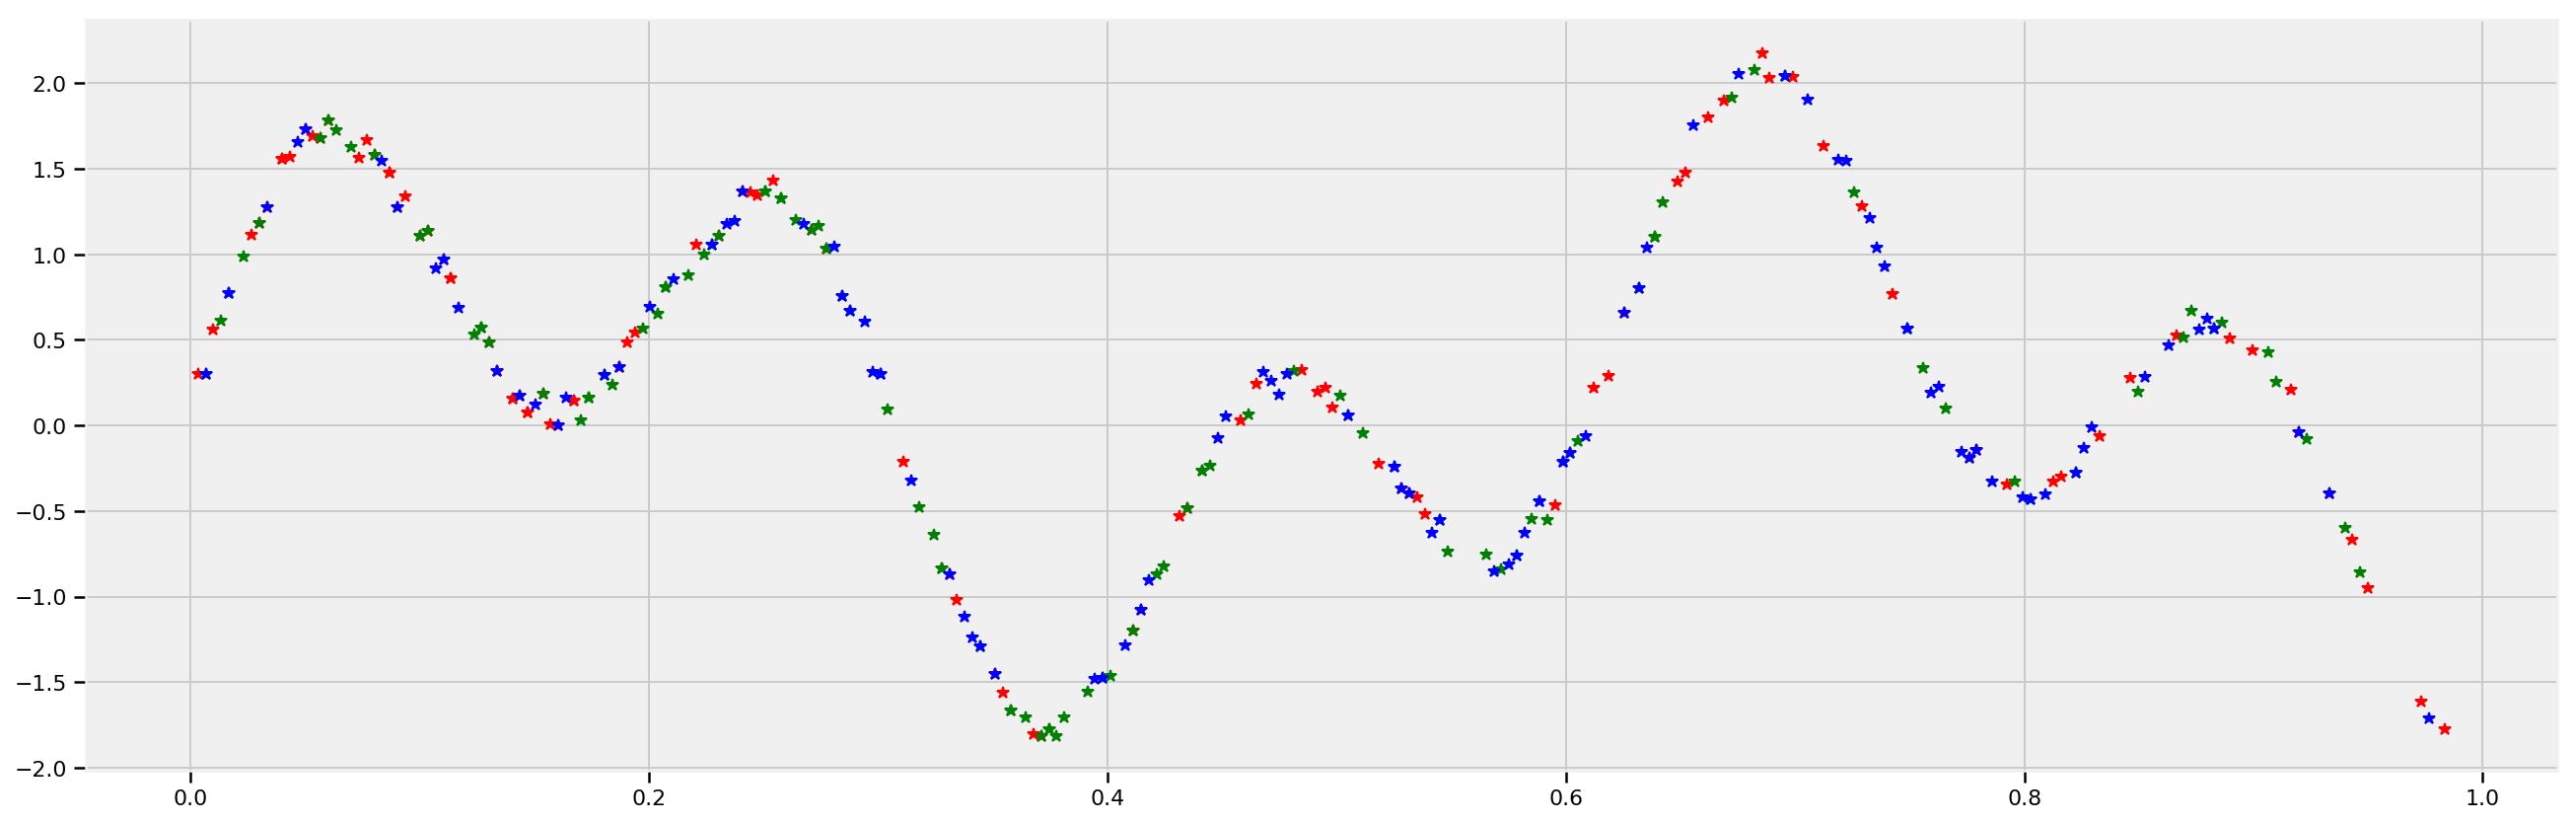

In [23]:
g3 = tf.Graph()

with g3.as_default():
  dataset_graph = tf.import_graph_def(gdef2, return_elements = ['X:0',"y:0", 'next'])
  next_ = g3.get_tensor_by_name('import/next:0')
  
  with tf.Session() as sess:
        for i in range(num_samples):
            X_, y_ = sess.run(next_)

            plt.plot(X_,y_,"{}*".format(colors[i]))



Shuffling is preserved!

Now the shufflebuffer includes the whole dataset and we have loads of randomness in the sequence to work with.


We will load this into the graph of a neural network in [which notebook?]